In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from datetime import datetime
from mlxtend.plotting import plot_decision_regions

# Import Developer API App credentials:
import credentials

# Create spotify authentication
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=credentials.client_id, 
                                               client_secret=credentials.client_secret, 
                                               redirect_uri=credentials.redirect_url))

In [2]:
## Create function to pull desired features/variables from the Spotify API's JSON/Python dictionary response.
def unnest_playlist(creator, playlist_id):
    '''
    unnest_playlist()
    Takes playlist author name and playlist ID as inputs
    Returns Pandas Data Frame with desired features.
    '''
    
    ## Create list of feature names
    p_feature_selections = ["artist", "album", "album_release_date", "track_name", 
                            "track_id", "popularity", "danceability", "energy", "key", 
                            "loudness", "mode", "speechiness", "instrumentalness", "liveness",
                            "valence", "tempo", "duration_ms", "time_signature"]
    
    ## Create empty pandas dataframe with feature names as columns
    playlist_df = pd.DataFrame(columns = p_feature_selections)
    
    ## Send request to Spotify API using user_playlist_tracks() function to obtain playlist
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    
    ## Loop through tracks in playlist dictionary
    for track in playlist:
        ## Create empty feature dictionary and add features based on their locations in the track dictionary
        p_features = {}
        p_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        p_features["album"] = track["track"]["album"]["name"]
        p_features["album_release_date"] = track["track"]["album"]['release_date']
        p_features["track_name"] = track["track"]["name"]
        p_features["track_id"] = track["track"]["id"]
        p_features['popularity'] = track['track']['popularity']
        
        ## Use audio_features() function to request audio features for the desired track.
        a_features = sp.audio_features(p_features["track_id"])[0]

        ## Loop through audio features and add them to the p_features dictionary.
        for feature in p_feature_selections[6:]:
            p_features[feature] = a_features[feature]

        ## Create Pandas Dataframe from playlist features dictionary
        track_df = pd.DataFrame(p_features, index = [0])
        ## concatenate playlist dataframe and track dataframe
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

    ## Return playlist_df
    return playlist_df


In [3]:
## Create playlist_queue which is a dictionary with playlist name, ID, and mood.
playlist_queue = {
    "playlist_name":['Have a Great Day!', "Mood Booster", "Happy Hits", "Feelin' Good", "Good Vibes",
                    "Sad Indie", "Sad 10s", "Sad 70s", "Sad 90s", "Sad Songs"],
    "playlist_id":["37i9dQZF1DX7KNKjOK0o75", "37i9dQZF1DX3rxVfibe1L0", "37i9dQZF1DXdPec7aLTmlC", 
                   "37i9dQZF1DX9XIFQuFvzM4", "37i9dQZF1DWYBO1MoTDhZI",
                  "37i9dQZF1DWVV27DiNWxkR", "37i9dQZF1DX8Vz2ROLXhTT", "37i9dQZF1DX6hO1vx5AApi", 
                   "37i9dQZF1DWZFicI79sEj9", "37i9dQZF1DX7qK8ma5wgG1"],
    "mood":["Happy", "Happy", "Happy", "Happy", "Happy",
           "Sad", "Sad", "Sad", "Sad", "Sad"]
}

## Create a pandas dataframe from playlist_queue dictionary
playlist_queue = pd.DataFrame(playlist_queue)

## Create empty list to store managed DFs
playlist_dfs = []

## Loop through playlists in playlist_queue
for p_id in range(len(playlist_queue)):
    ## Use unnest_playlist function to request the playlist from spotify, manage it, and return the Pandas DF
    df = unnest_playlist("spotify", playlist_queue.playlist_id[p_id])
    ## Add playlist_name feature to dataframe
    df['playlist_name'] = playlist_queue.playlist_name[p_id]
    ## Add mood feature to dataframe
    df['mood'] = playlist_queue.mood[p_id]
    ## Add managed playlist DF to the playlist_dfs list.
    playlist_dfs.append(df)
    
    ## Give a notification upon each iteration of the playlist that has just been queried and managed.
    print("{}: {} (ID:{})".format(playlist_queue.mood[p_id], 
                                  playlist_queue.playlist_name[p_id], 
                                  playlist_queue.playlist_id[p_id]))

Happy: Have a Great Day! (ID:37i9dQZF1DX7KNKjOK0o75)
Happy: Mood Booster (ID:37i9dQZF1DX3rxVfibe1L0)
Happy: Happy Hits (ID:37i9dQZF1DXdPec7aLTmlC)
Happy: Feelin' Good (ID:37i9dQZF1DX9XIFQuFvzM4)
Happy: Good Vibes (ID:37i9dQZF1DWYBO1MoTDhZI)
Sad: Sad Indie (ID:37i9dQZF1DWVV27DiNWxkR)
Sad: Sad 10s (ID:37i9dQZF1DX8Vz2ROLXhTT)
Sad: Sad 70s (ID:37i9dQZF1DX6hO1vx5AApi)
Sad: Sad 90s (ID:37i9dQZF1DWZFicI79sEj9)
Sad: Sad Songs (ID:37i9dQZF1DX7qK8ma5wgG1)


In [52]:
## Concatenate playlist dataframes in playlist_dfs list
playlist_joined = pd.concat(playlist_dfs)

In [53]:
## Find the number of duplicate tracks across the 10 playlists
n_duplicates = playlist_joined.duplicated(subset = ['track_id'], keep = 'first').value_counts()[1]
print("There were {} duplicate tracks".format(n_duplicates))

There were 58 duplicate tracks


In [54]:
## Remove Duplicate Tracks (keeps first occurence of duplicate and drops the rest)
playlist_joined.drop_duplicates(subset = ['track_id'], keep = 'first', inplace = True)

In [55]:
## Convert album_release_date to a DateTime Object:
playlist_joined['album_release_date'] = pd.to_datetime(playlist_joined.album_release_date)
## create yrs_since_release feature by subtracting album_release_date year from the current year.
playlist_joined['yrs_since_release'] = datetime.now().year - playlist_joined.album_release_date.dt.year

In [56]:
## See counts of tracks within each mood.
playlist_joined.mood.value_counts()

Happy    446
Sad      345
Name: mood, dtype: int64

In [57]:
## Get shape of the dataframe
playlist_joined.shape

(791, 21)

### Exploratory Data Analysis
---

In [169]:
## Create plotting data by grouping by mood and taking the count of tracks:
mood_plt_df = playlist_joined.groupby(['mood']).mood.count()
mood_plt_df

mood
Happy    446
Sad      345
Name: mood, dtype: int64

(0, 500)

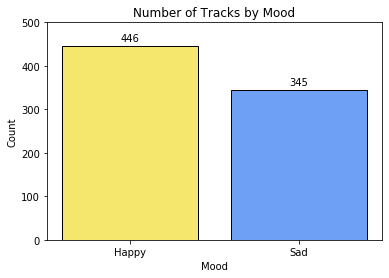

In [69]:
## Bar plot of the count of tracks within each mood
plt.bar(mood_plt_df.index, mood_plt_df.mood, edgecolor = 'k', color = ['#f5e76e','#6ea0f5'])
## Add labels to plot
plt.ylabel('Count')
plt.xlabel('Mood')
plt.title('Number of Tracks by Mood')
## Iterate through the indices of mood_plt_df to annotate each bar with its associated y value.
for idx in range(len(mood_plt_df)):
    plt.annotate(str(mood_plt_df.mood[idx]),
                 (idx, mood_plt_df.mood[idx]), 
                 ha='center', va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')
## Set y axis limits
plt.ylim((0,500))

In [12]:
## Get average value for select features, grouped by mood
feat_plt_df = playlist_joined.groupby(['mood'])[['energy', 'loudness', 'speechiness',
                                                'liveness', 'yrs_since_release', 'danceability']].mean()

Text(0, 0.5, 'Danceability')

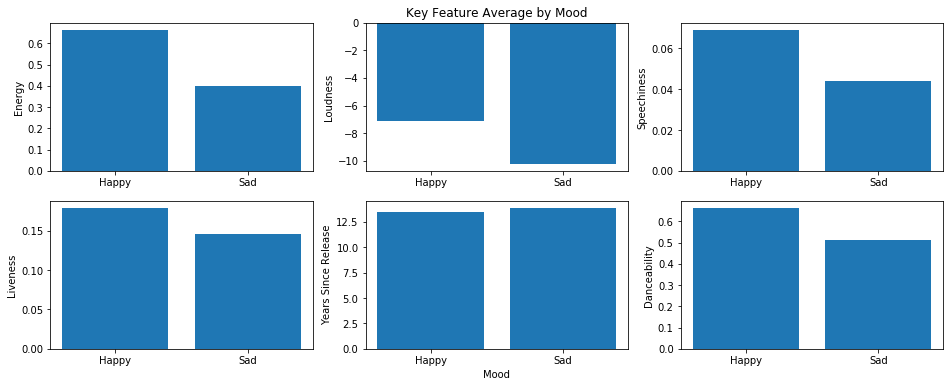

In [13]:
## Plot these averages
plt.figure(1, figsize = (16,6))

plt.subplot(231)
plt.bar(feat_plt_df.index, feat_plt_df.energy)
plt.ylabel("Energy")

plt.subplot(232)
plt.bar(feat_plt_df.index, feat_plt_df.loudness)
plt.ylabel("Loudness")
plt.title("Key Feature Average by Mood")

plt.subplot(233)
plt.bar(feat_plt_df.index, feat_plt_df.speechiness)
plt.ylabel("Speechiness")

plt.subplot(234)
plt.bar(feat_plt_df.index, feat_plt_df.liveness)
plt.ylabel("Liveness")

plt.subplot(235)
plt.bar(feat_plt_df.index, feat_plt_df.yrs_since_release)
plt.ylabel("Years Since Release")
plt.xlabel("Mood")

plt.subplot(236)
plt.bar(feat_plt_df.index, feat_plt_df.danceability)
plt.ylabel("Danceability")

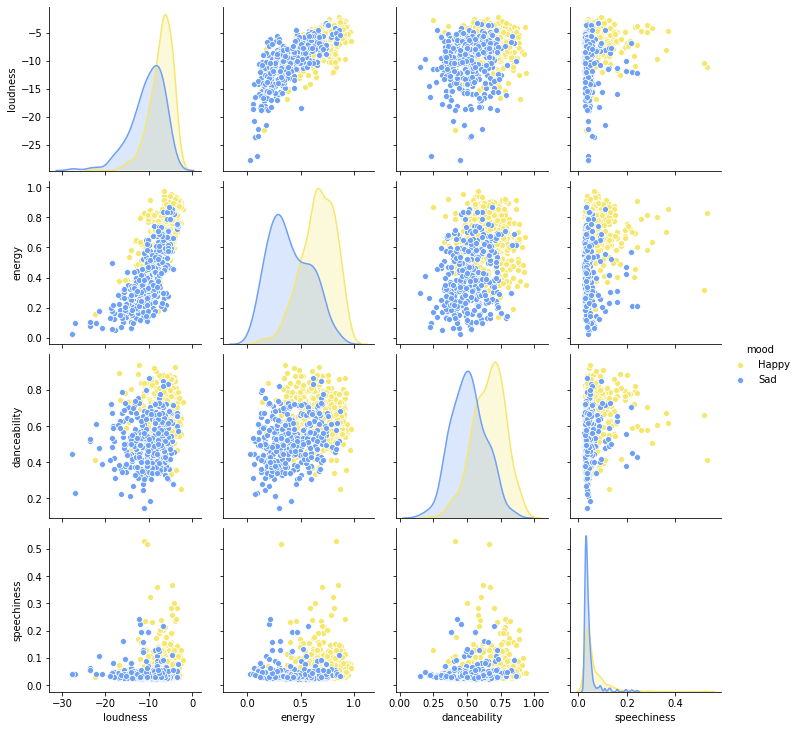

In [73]:
## Plot relationships between select numeric features, by mood.
sns.pairplot(playlist_joined[['loudness', 'energy', 'danceability', 'mood', 'speechiness']], 
             hue = 'mood', palette = ['#f5e76e','#6ea0f5']);

In [17]:
## Observe summary statistics of numeric features.
playlist_joined.describe()

,danceability,energy,loudness,speechiness,liveness,valence,tempo,yrs_since_release
count,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000
mean,0.598186,0.548493,-8.482475,0.058009,0.164867,0.494803,119.495858,13.652339
std,0.143594,0.217554,3.632459,0.050384,0.130740,0.264119,26.992282,17.374118
min,0.149000,0.026100,-27.753000,0.022000,0.024600,0.038400,58.555000,0.000000
25%,0.498000,0.373500,-10.345000,0.033000,0.093350,0.257000,100.050000,1.000000
50%,0.597000,0.584000,-7.780000,0.040900,0.115000,0.481000,118.118000,4.000000
75%,0.709500,0.714000,-5.966500,0.058800,0.178500,0.721500,134.176000,23.000000
max,0.936000,0.975000,-2.200000,0.529000,0.832000,0.982000,208.282000,63.000000


In [18]:
## Binarize response variable (Mood):
# 0 - Happy, 1 - Sad
playlist_joined = pd.get_dummies(playlist_joined, columns = ['mood'], drop_first = True)
playlist_joined.rename(columns = {"mood_Sad":"mood"}, inplace = True)

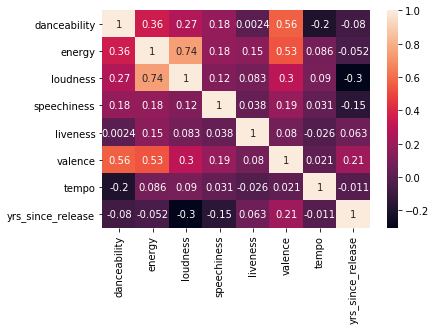

In [170]:
## Use correlations to select predictor features for the model.
sns.heatmap(playlist_joined.corr(), annot = True)

## Modeling

---

Creating and evaluating models to predict whether a song is "happy" or "sad".

- Logistic Regression

- K-Nearest Neighbors

In [20]:
## Define predictor features for model.
X_feats = ['danceability', 'energy', 'loudness', 'speechiness', 'liveness', 'tempo']

## Create subset of selected features
X = playlist_joined[X_feats]

## Instantiate scaler
scaler = StandardScaler()
## fit data with scaler
X_scaled = scaler.fit_transform(X)

## set response variable to y (mood)
y = playlist_joined.mood

## Create training/testing splits (70%-train, 30%-test; default)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 24)

#### Logistic Regression

In [21]:
## Instantiate Logistic Regression Model
glm = LogisticRegression()

## Fit Logistic Regression Model
glm.fit(X_train, y_train)

## Predict y with test data
y_pred_glm = glm.predict(X_test)

In [22]:
## Print Classification Report to evaluate results using actual y and predicted y
print(cr(y_test, y_pred_glm))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       111
           1       0.84      0.86      0.85        87

    accuracy                           0.87       198
   macro avg       0.87      0.87      0.87       198
weighted avg       0.87      0.87      0.87       198



#### K-Nearest Neighbors

In [23]:
## Create empty list to store test accuracies
test_accuracies = []

## Iterate through different K values (1 through 40, not including 40)
for k in range(1, 40):
    ## Instantiate model with current k value
    knn = KNeighborsClassifier(n_neighbors = k)
    ## Fit model on training data
    knn.fit(X_train, y_train)
    ## Predict y with test data
    pred_k = knn.predict(X_test)
    ## get accuracy and append this value to the test_accuracies list.
    test_accuracies.append(np.mean(pred_k == y_test))

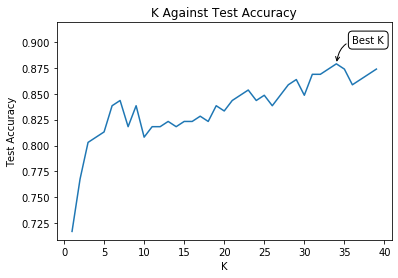

In [24]:
## Create range object with k values we tested
k_values = range(1, 40)

## Set x max
xmax = k_values[test_accuracies.index(max(test_accuracies))]
## Set y max
ymax = max(test_accuracies)

## Plot accuracies for each value of k
plt.plot(k_values, test_accuracies)
## Set y limits based on the ymax + .04 cushion
plt.ylim(top=ymax+.04)
plt.title('K Against Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('K')
## Annotate the max K value using the xmax and ymax values we set.
plt.annotate("Best K", xy = (xmax, ymax), xytext = (xmax+2, ymax+.02),
            bbox=dict(boxstyle="round,pad=.4", fc="1"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"));

In [25]:
# Get k value that resulted in highest accuracy
best_accuracy = max(test_accuracies)
k_values[test_accuracies.index(best_accuracy)]

34

In [26]:
## Instantiate KNN model with our best K value
knn = KNeighborsClassifier(n_neighbors = 34)
## Train this model with the training data
knn.fit(X_train, y_train)
## Predict y with the test data
y_pred_knn = knn.predict(X_test)

In [27]:
## Print classification report to evaluate results
print(cr(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       111
           1       0.89      0.83      0.86        87

    accuracy                           0.88       198
   macro avg       0.88      0.87      0.88       198
weighted avg       0.88      0.88      0.88       198



#### Random Forest

In [28]:
## Instantiate Random Forest Model with 100 trees.
rf = RandomForestClassifier(n_estimators=100)

## Fit model with training data
rf.fit(X_train, y_train)

## Predict y with test data
y_pred_rf = rf.predict(X_test)

## Print classification report to evaluate results
print(cr(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       111
           1       0.86      0.82      0.84        87

    accuracy                           0.86       198
   macro avg       0.86      0.85      0.86       198
weighted avg       0.86      0.86      0.86       198



### Predicting on New Data

In [30]:
## Import my own spotify library
## (I ran this in a separate python file and exported the pandas DF to csv.)
my_songs = pd.read_csv("my_songs.csv", index_col = 0)

In [31]:
## Transform new data with the scaler we had fit on the original dataset
new_df_scaled = scaler.transform(my_songs[X_feats])

In [32]:
## Predict and store y predictions in dataframe
my_songs['mood_pred'] = knn.predict(new_df_scaled)

In [34]:
## Explore sad songs -- pretty good at a glance! (from my own awareness of what I've listened to
## when I've been sad)
my_songs[my_songs.mood_pred == 1]

,song_id,song_name,artist,popularity,is_explicit,album_name,album_release_date,danceability,energy,key,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,mood_pred
3,3ri4y4r1BFc9YiPNgFXeGW,Obvious Bicycle,Vampire Weekend,48.0,0.0,Modern Vampires of the City,2013-05-13,0.661,0.282,9,...,0.120,89.997,audio_features,3ri4y4r1BFc9YiPNgFXeGW,spotify:track:3ri4y4r1BFc9YiPNgFXeGW,https://api.spotify.com/v1/tracks/3ri4y4r1BFc9...,https://api.spotify.com/v1/audio-analysis/3ri4...,251253,4,1
32,1pmImsdC9t35L3TkD26ax8,Nuclear Fusion,King Gizzard & The Lizard Wizard,41.0,0.0,Flying Microtonal Banana,2017-02-24,0.390,0.780,11,...,0.586,86.363,audio_features,1pmImsdC9t35L3TkD26ax8,spotify:track:1pmImsdC9t35L3TkD26ax8,https://api.spotify.com/v1/tracks/1pmImsdC9t35...,https://api.spotify.com/v1/audio-analysis/1pmI...,255453,4,1
33,22KN1nRkp0H5foRTR950Iv,Sex Dream; Marine,infinite bisous,39.0,0.0,Period,2019-03-11,0.631,0.216,1,...,0.349,79.600,audio_features,22KN1nRkp0H5foRTR950Iv,spotify:track:22KN1nRkp0H5foRTR950Iv,https://api.spotify.com/v1/tracks/22KN1nRkp0H5...,https://api.spotify.com/v1/audio-analysis/22KN...,210173,1,1
35,0DgWa8oXi3wn3Q67MaHRdw,Half-Light (feat. Kelly Zutrau),Rostam,48.0,0.0,Half-Light,2017-09-15,0.313,0.478,2,...,0.427,71.074,audio_features,0DgWa8oXi3wn3Q67MaHRdw,spotify:track:0DgWa8oXi3wn3Q67MaHRdw,https://api.spotify.com/v1/tracks/0DgWa8oXi3wn...,https://api.spotify.com/v1/audio-analysis/0DgW...,211013,4,1
38,60k0xRw1oYUwZYp4e2iue8,american dream,LCD Soundsystem,43.0,0.0,american dream,2017-09-01,0.295,0.540,0,...,0.199,202.015,audio_features,60k0xRw1oYUwZYp4e2iue8,spotify:track:60k0xRw1oYUwZYp4e2iue8,https://api.spotify.com/v1/tracks/60k0xRw1oYUw...,https://api.spotify.com/v1/audio-analysis/60k0...,366787,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,0o1N4jfVOXErcR82UKxfO8,Shadow,Wild Nothing,45.0,0.0,Nocturne,2012-08-28,0.450,0.724,8,...,0.595,138.065,audio_features,0o1N4jfVOXErcR82UKxfO8,spotify:track:0o1N4jfVOXErcR82UKxfO8,https://api.spotify.com/v1/tracks/0o1N4jfVOXEr...,https://api.spotify.com/v1/audio-analysis/0o1N...,258779,4,1
1166,4mNFQGXQmTCdyhAGjaNVSb,Before The Dive,St. Lucia,37.0,0.0,St. Lucia,2012-03-06,0.488,0.742,9,...,0.527,146.889,audio_features,4mNFQGXQmTCdyhAGjaNVSb,spotify:track:4mNFQGXQmTCdyhAGjaNVSb,https://api.spotify.com/v1/tracks/4mNFQGXQmTCd...,https://api.spotify.com/v1/audio-analysis/4mNF...,279267,4,1
1201,5y0nFFgYV7ugOq4ZXrExoB,Kites,Geographer,37.0,0.0,Animal Shapes,2010-03-09,0.427,0.700,2,...,0.151,85.999,audio_features,5y0nFFgYV7ugOq4ZXrExoB,spotify:track:5y0nFFgYV7ugOq4ZXrExoB,https://api.spotify.com/v1/tracks/5y0nFFgYV7ug...,https://api.spotify.com/v1/audio-analysis/5y0n...,263347,4,1
1207,1eBTht68sEPetrGkM5HQiN,Hearts Like Ours,The Naked And Famous,0.0,0.0,Hearts Like Ours,2013-01-01,0.372,0.667,6,...,0.151,177.901,audio_features,1eBTht68sEPetrGkM5HQiN,spotify:track:1eBTht68sEPetrGkM5HQiN,https://api.spotify.com/v1/tracks/1eBTht68sEPe...,https://api.spotify.com/v1/audio-analysis/1eBT...,272053,4,1


In [40]:
## Explore top artists by count of sad songs
my_songs[my_songs.mood_pred == 1].groupby(['artist']).artist.count().sort_values(ascending = False).head(10)

artist
Frankie Cosmos            9
Various Artists           9
Youth Lagoon              8
Gus Dapperton             7
Rostam                    5
Japanese Breakfast        5
Vampire Weekend           5
Dreamgirl                 4
Alex G                    4
Francis and the Lights    4
Name: artist, dtype: int64

In [41]:
## Explore top artists by count of happy songs
my_songs[my_songs.mood_pred == 0].groupby(['artist']).artist.count().sort_values(ascending = False).head(10)


artist
Vampire Weekend             21
The Strokes                 15
Little Dragon               13
Gus Dapperton               13
Jai Paul                    13
Blood Orange                12
Still Woozy                 11
Unknown Mortal Orchestra    10
Kendrick Lamar              10
Phoenix                      9
Name: artist, dtype: int64

In [48]:
## Rank artists by count of sad songs and display percent/proportion of their music in my library that's sad.
my_songs.groupby(['artist']).mood_pred.agg({"mean", "count"}).sort_values(by = "count", ascending = False).head(11)


,count,mean
artist,,
Vampire Weekend,26,0.192308
Gus Dapperton,20,0.350000
The Strokes,18,0.166667
Frankie Cosmos,18,0.500000
Youth Lagoon,17,0.470588
Various Artists,17,0.529412
Little Dragon,15,0.133333
Jai Paul,14,0.071429
Blood Orange,14,0.142857


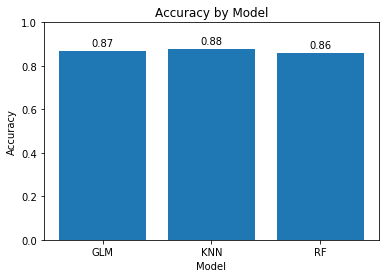

In [172]:
## Plot best accuracy for each model:
## Create list of accuracies for y axis
accuracies = [accuracy_score(y_test, y_pred_glm),
              accuracy_score(y_test, y_pred_knn),
              accuracy_score(y_test, y_pred_rf)]
## Create list of model names for x axis
a_labels = ["GLM", "KNN", "RF"]

## Plot barplot
plt.bar(a_labels, accuracies)
plt.ylim((0,1))

## Add annotated accuracy labels for each bar
for idx in range(len(accuracies)):
    plt.annotate(str(accuracies[idx].round(2)),
             (idx, accuracies[idx]), 
             ha='center', va='center',
             size=10, xytext=(0, 8),
             textcoords='offset points')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model');

In [127]:
## Create new KNN model with 2 features to showcase decision boundaries:
knn_viz = KNeighborsClassifier(n_neighbors = 34)
knn_viz.fit(X_train[:,0:2], y_train)
y_pred_viz = knn_viz.predict(X_test[:,0:2])

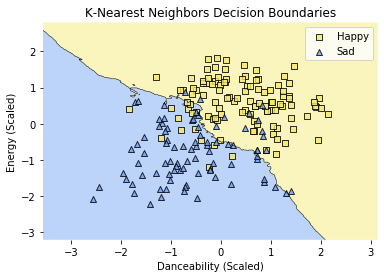

In [147]:
## Use plot_decision_regions() function to plot decision boundaries within
## the feature space of the energy and danceability features.
plot_decision_regions(X_test[:,0:2], np.array(y_test), clf=knn_viz, colors = '#f5e76e,#6ea0f5')
plt.xlabel('Danceability (Scaled)')
plt.ylabel('Energy (Scaled)')
plt.title('K-Nearest Neighbors Decision Boundaries')

## Re-label legend with response labels:
leg = plt.legend()
leg.get_texts()[0].set_text('Happy')
leg.get_texts()[1].set_text('Sad');